# Plot profiles of rolling averaged epsilon and temperature and salinity 

Following code uses CTD data and microstructure data to plot profiles of epsilon, temperauture and salinity, uncomment oxgen to include this. Also plots T-S curves of epsilon data for each ctd profile in yoyo

Some code to open open and read ctd data adapted from megan jeffers ctd_transects

In [2]:
# load some standard packages - will not need all for this notebook

import numpy as np
import xarray as xr
import matplotlib
import math
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import calendar

import os
import re
import pandas as pd

import matplotlib.gridspec as gridspec

from scipy.stats import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.patches as patches

import gsw_xarray as gsw # seawater calculations

/Users/isabelaconde/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [42]:
# read_nc_file function adapted from megan's code
def read_nc_file(file):

    # ds = xr.open_dataset(file)
    ds=xr.open_dataset(file, engine='netcdf4')

    # Extract the variables
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    salinity = ds['salinity'].values
    oxygen = ds['oxygen'].values
    latitude = ds['latitude'].values[0]
    longitude = ds['longitude'].values[0]
    time = ds['time'].values[0]

    pressure_reshaped = np.reshape(pressure, (1, 1, len(pressure), 1))

    # calculate absolute salinity
    SA = gsw.SA_from_SP(salinity, pressure_reshaped, longitude, latitude)
    # calculate conservative temperature 
    CT = gsw.CT_from_t(SA, temperature, pressure_reshaped)
    # calulate density 
    density = gsw.density.rho(SA,CT,pressure_reshaped)
    # Calculate depth
    depth = gsw.z_from_p(pressure, latitude)
    # Create an xarray DataArray with explicit dimension names
    density_da = xr.DataArray(
        density,
        dims=['longitude','latitude','pressure','time'],
        coords={'longitude': longitude,
                'latitude': latitude,
                'pressure': pressure,
                'time': time}
    )
    pressure_da = xr.DataArray(
        pressure,
        dims=['depth'],
        coords={'depth': depth}
    )
    # Create a new xarray dataset with explicit dimension names
        # Create the dataset
    new_ds = xr.Dataset(
        {
            'temperature': (('longitude', 'latitude', 'depth', 'time'), temperature),
            'salinity': (('longitude', 'latitude', 'depth', 'time'), salinity),
            'oxygen': (('longitude', 'latitude', 'depth', 'time'), oxygen),
            'density': (('longitude', 'latitude', 'depth', 'time'), density_da.data),
            'pressure': (pressure_da.dims, pressure_da.data)
        },
        coords={
            'longitude': ('longitude', [longitude]),
            'latitude': ('latitude', [latitude]),
            'depth': ('depth', depth),
            'time': ('time', [time]),
        }
    )
    return new_ds

data_list = []
def open_nc_files(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out only .nc files
    nc_files = [file for file in files if file.endswith('.nc')]
    
    # Open and process each .nc file
    for nc_file in nc_files:
        file_path = os.path.join(folder_path, nc_file)

        # Extract the numeric part '046' from the filename
        numeric_part = ''.join(filter(str.isdigit, nc_file))[-3:]
        
        # Create the variable name
        variable_name = f"ctd_{numeric_part}"
        try:
            dataset = read_nc_file(file_path)
            # print('file read')
            # Assign the dataset to the variable name in the global scope
            globals()[variable_name] = dataset

            latitude = dataset['latitude'].values[0]
            longitude = dataset['longitude'].values[0]

            data_list.append({
                'ctd': variable_name,
                'latitude': latitude,
                'longitude': longitude
            })

        except Exception as e:
            print(f"Failed to open {nc_file}: {e}")
    df = pd.DataFrame(data_list)
    df.to_csv('/Users/isabelaconde/Desktop/ctd_coordinates.csv', index=False)

# Specify the folder containing .nc files
folder_path = '/Users/isabelaconde/Desktop/avg'


open_nc_files(folder_path)

# load the ctd_ops dataset
variable_names = [var_name for var_name in globals() if var_name.startswith('ctd_')] # run before loading ctd_ops dataset

In [43]:

# Replace 'path_to_file.xlsx' with the path to your Excel file
file_path = '/Users/isabelaconde/Desktop/ctd_file_mapping.xlsx'

# Read only columns C and F from the Excel file
df = pd.read_excel(file_path, sheet_name='Sheet1')

ctd_ops = []
for i in range(len(df['File name'])):
    if pd.notna(df['File name'][i]):
        # print(df['ctd num'][i])
        ctd_ops.append(df['ctd num'][i])



In [44]:
# Initialize a dictionary to store the results
yoyo_dict = {}

# Iterate through the DataFrame rows
for _, row in df.dropna().iterrows():
    yoyo_num = row['yoyo num']
    
    # If the yoyo_num key does not exist in the dictionary, create it
    if yoyo_num not in yoyo_dict:
        yoyo_dict[yoyo_num] = {'ctds': [], 'microrider': []}
    
    # Append the ctd and microrider values to the corresponding lists
    yoyo_dict[yoyo_num]['ctds'].append(row['ctd num'])
    yoyo_dict[yoyo_num]['microrider'].append(row['File name'])

yoyo_dict[1]

{'ctds': ['ctd_017', 'ctd_018', 'ctd_019', 'ctd_020', 'ctd_021'],
 'microrider': ['DAT_015', 'DAT_016', 'DAT_017', 'DAT_018', 'DAT_019']}

### Open 12hr yoyo .nc files 

nc files with chi and epsilon processed from .mat files using ]

In [45]:

# Initialize a dictionary to store the datasets
datasets = {}

# Directory path for the files
base_path = '/Users/isabelaconde/Desktop/microstructure/'

# Open datasets dynamically
for yoyo, data in yoyo_dict.items():
    for microrider in data['microrider']:
        file_name = f'{microrider}_eps_chi.nc'
        file_path = base_path + file_name
        datasets[microrider] = xr.open_dataset(file_path)

# Print the keys of the datasets to verify
print(datasets.keys())


dict_keys(['DAT_015', 'DAT_016', 'DAT_017', 'DAT_018', 'DAT_019', 'DAT_020', 'DAT_022', 'DAT_023', 'DAT_024', 'DAT_025', 'DAT_027', 'DAT_028', 'DAT_030', 'DAT_026', 'DAT_029', 'DAT_031', 'DAT_040', 'DAT_041', 'DAT_042', 'DAT_043', 'DAT_044', 'DAT_045', 'DAT_050', 'DAT_051', 'DAT_052', 'DAT_053', 'DAT_054', 'DAT_058', 'DAT_060', 'DAT_062', 'DAT_064', 'DAT_066', 'DAT_059', 'DAT_061', 'DAT_063', 'DAT_065', 'DAT_067', 'DAT_079', 'DAT_080', 'DAT_081', 'DAT_083', 'DAT_084'])


In [5]:

def read_nc_file(file):
    ds = xr.open_dataset(file)
    pressure = ds['pressure'].values.flatten()
    temperature = ds['temperature'].values.flatten()
    salinity = ds['salinity'].values.flatten()
    oxygen = ds['oxygen'].values.flatten()
    latitude = ds['latitude'].values.flatten()[0]
    longitude = ds['longitude'].values.flatten()[0]
    time = ds['time'].values.flatten()[0]
    ds.close()
    return pressure, temperature, salinity, oxygen, latitude, longitude, time

def process_casts(files, indices):
    casts = []
    for i in indices:
        file = files[i]
        pressure, temperature, salinity, oxygen, latitude, longitude, time = read_nc_file(file)
        cast = {
            'pressure': pressure,
            'temperature': temperature,
            'salinity': salinity,
            'oxygen': oxygen,
            'latitude': latitude,
            'longitude': longitude,
            'time': time
        }
        casts.append(cast)
    return casts





## Calculate N^2 

gsw package: finding N2 need SA, CT p and lat. to find CT need SA, t and p 

In [59]:

def nsquarred(ctd_data):
    sp = ctd_data['salinity'].isel(time=0,latitude=0,longitude=0)
    temp = ctd_data['temperature'].isel(time=0,latitude=0,longitude=0)
    p = ctd_data['pressure']

    sa = gsw.SA_from_SP(sp, p, ctd_data['longitude'].values, ctd_data['latitude'].values)
    CT = gsw.CT_from_t(sa, temp, p)

    [N2,p_mid] = gsw.Nsquared(sa, CT, p, lat=ctd_data['latitude'].values,axis=0)
    
    return N2, p_mid


#### function to plot T-S curves 

In [60]:
# function to plot T-S diagram with isopycnals and scatter plot of epsiolon 

def plot_ts_diagram(datasets, ctd_data,labels):

    # Assuming ctd_17 is defined somewhere as it is in the original code
    ctd_pressure = ctd_data.pressure.values
    ctd_temperature = ctd_data.temperature[0, 0, :, 0].values
    ctd_salinity = ctd_data.salinity[0, 0, :, 0].values

    # Collect temperature and salinity ranges across all datasets for plotting isopycnals
    all_temps = []
    all_sals = []

    for dataset in datasets.values():
        temp_interp = np.interp(dataset.pressure.values, ctd_pressure, ctd_temperature)
        salinity_interp = np.interp(dataset.pressure.values, ctd_pressure, ctd_salinity)
        all_temps.extend(temp_interp)
        all_sals.extend(salinity_interp)

    # Define the min / max values for plotting isopycnals
    t_min = np.nanmin(all_temps) - 1
    t_max = np.nanmax(all_temps) + 1
    s_min = np.nanmin(all_sals) - 1
    s_max = np.nanmax(all_sals) + 1

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(np.ceil(s_max - s_min) / 0.1)
    ydim = int(np.ceil(t_max - t_min))
    dens = np.zeros((ydim, xdim))

    # Create temp and salt vectors of appropriate dimensions
    ti = np.linspace(0, ydim, ydim) + t_min
    si = np.linspace(1, xdim, xdim) * 0.1 + s_min

    # Loop to fill in grid with densities
    for j in range(0, ydim):
        for i in range(0, xdim):
            dens[j, i] = gsw.rho(si[i], ti[j], 0)

    # Subtract 1000 to convert to sigma-t
    dens = dens - 1000

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    # Iterate through each dataset to plot
    for i, (key, dataset) in enumerate(datasets.items()):
        ax = axes[i]
        temp_interp = np.interp(dataset.pressure.values, ctd_pressure, ctd_temperature)
        salinity_interp = np.interp(dataset.pressure.values, ctd_pressure, ctd_salinity)
        eps = dataset.eps.values
        
        CS = ax.contour(si, ti, dens, linestyles='dashed', colors='k')
        ax.clabel(CS, fontsize=12, inline=1, fmt='%.2f')  # Label every second level
        scatter = ax.scatter(salinity_interp, temp_interp, c=eps, cmap=plt.cm.inferno, lw=0,vmin=-13,vmax=-8)
        
        ax.set_xlabel('Salinity (PSU)')
        ax.set_ylabel('Temperature (degC)')
        ax.set_title(labels[i])

    # Adjust layout and add colorbar
    plt.tight_layout()
    cbar = fig.colorbar(scatter, ax=axes, label=f'($\log_{{10}} \epsilon$)', orientation='vertical', pad=0.01, aspect=50)
    plt.show()

 



## Yoyo 1

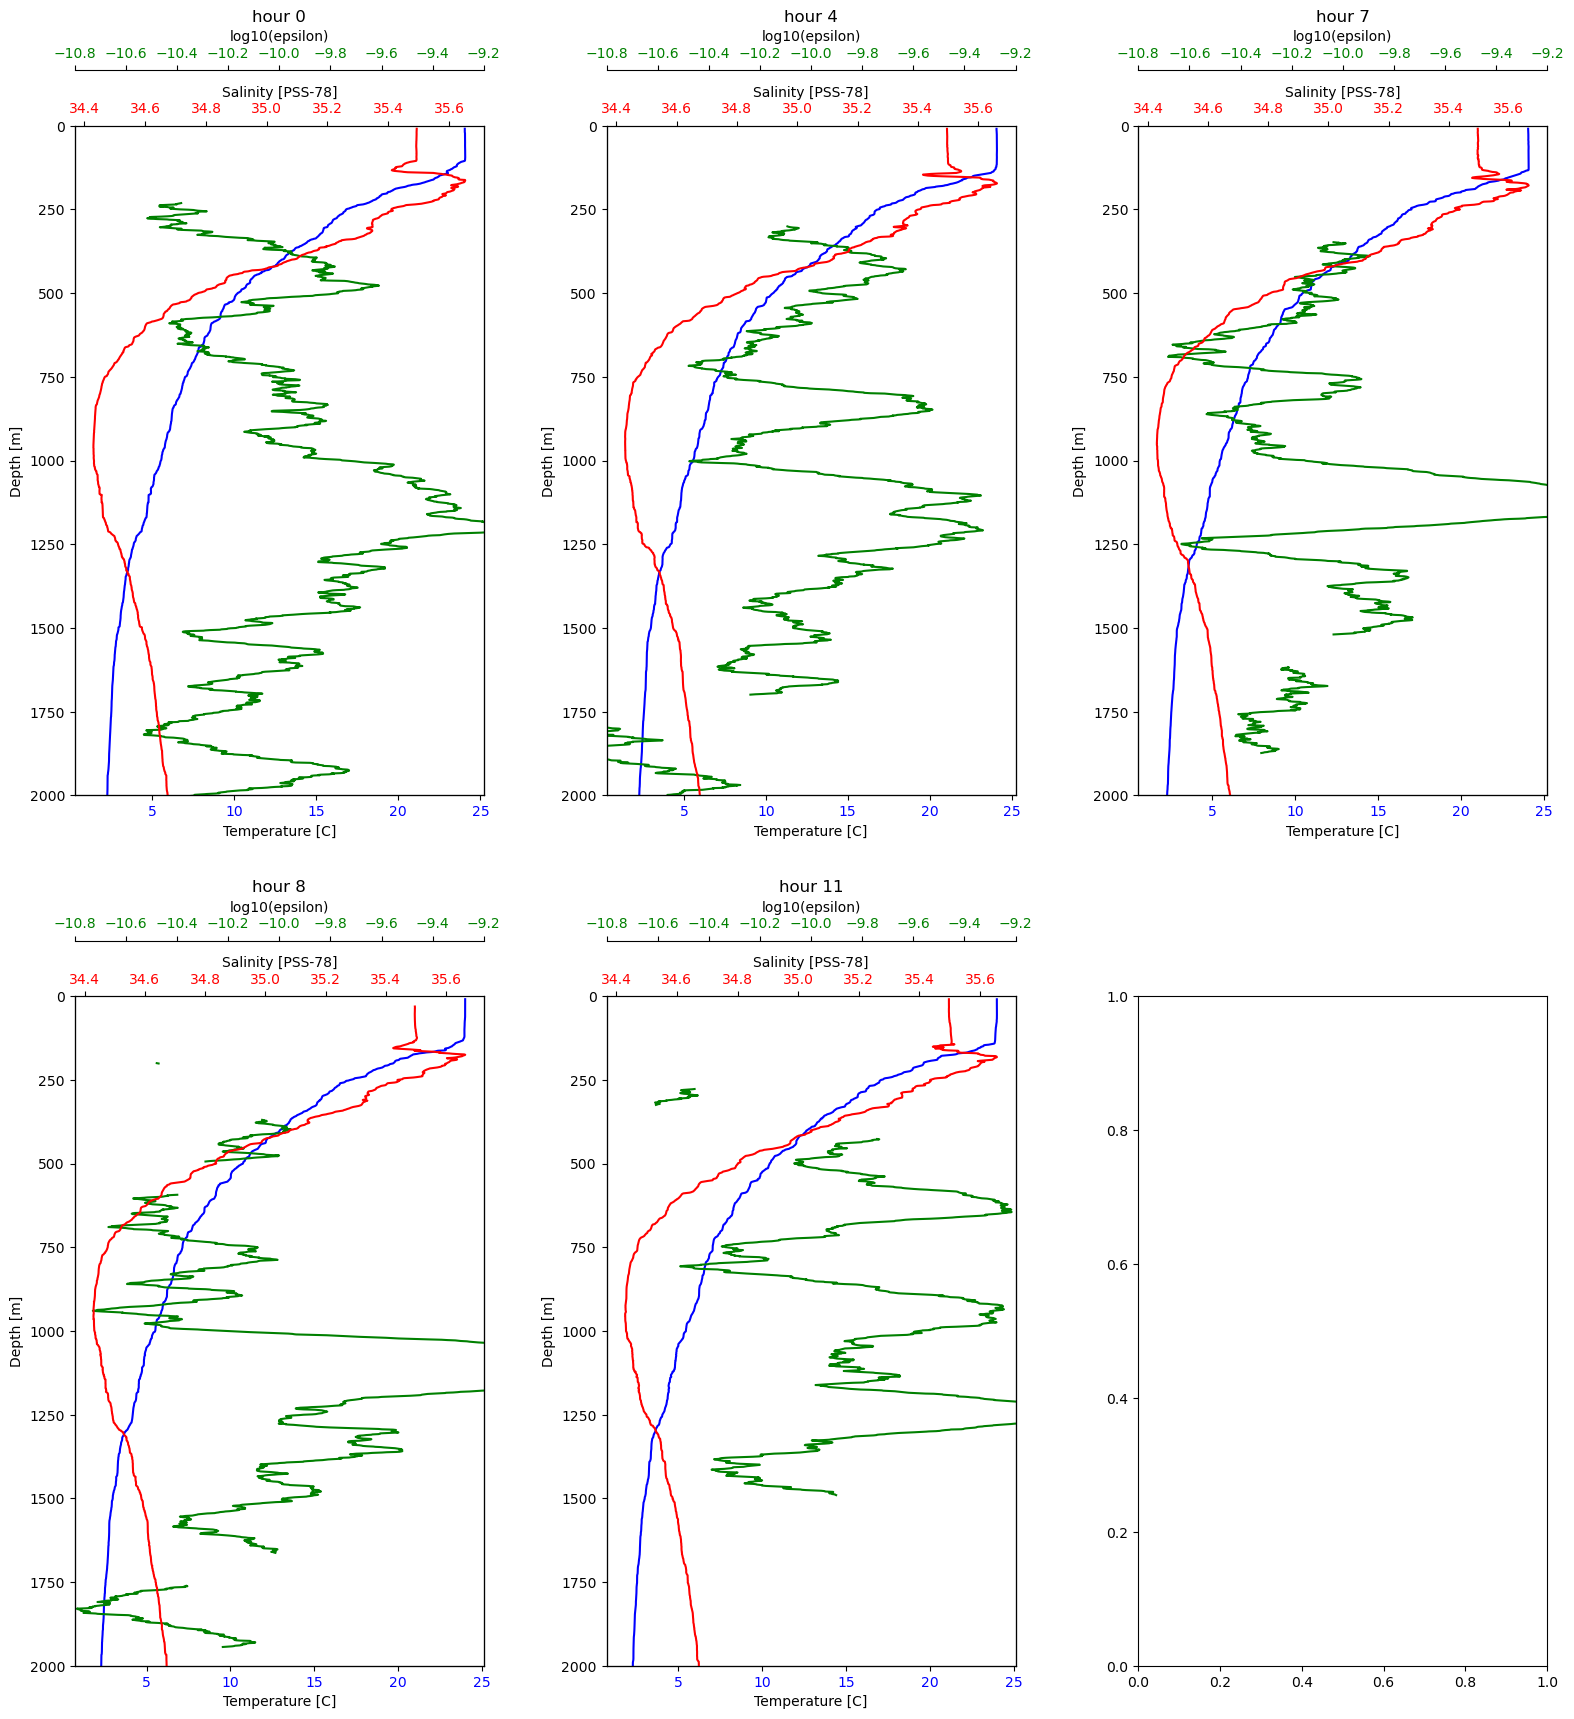

<Figure size 640x480 with 0 Axes>

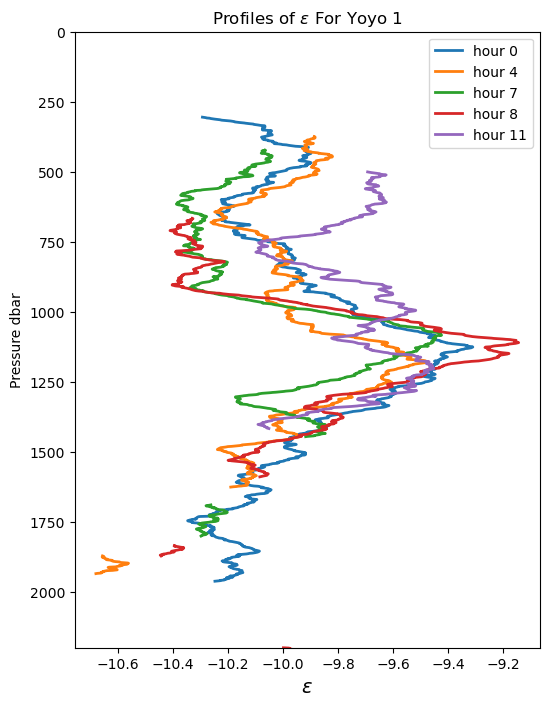

In [58]:

nc_files_dir = '/Users/isabelaconde/Desktop/ctds'
names = ['in2024_v04017CtdAvg.nc','in2024_v04018CtdAvg.nc','in2024_v04019CtdAvg.nc','in2024_v04020CtdAvg.nc','in2024_v04021CtdAvg.nc']
# List all .nc files in the directory
ctd_17 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_18 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_19 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
ctd_20 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))


dat_015 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
dat_016 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_016.nc')
dat_017 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_017.nc')
dat_018 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_018.nc')
dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_019.nc')

                    


datasets= [ctd_17,ctd_18,ctd_19,ctd_20,ctd_21]
eps = [dat_015['eps'],dat_016['eps'],dat_017['eps'],dat_018['eps'],dat_019['eps']]

label = ['hour 0', 'hour 4', 'hour 7', 'hour 8', 'hour 11']

n2_dict = {}
p_mid_dict = {}

for i, data in enumerate(datasets):
    n2, p_mid = nsquarred(data)
    p_mid_dict[f"Dataset_{i+1}"] = p_mid
    n2_dict[f"Dataset_{i+1}"] = n2



# Create the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(19, 20))
axes = axes.flatten()

for i, data in enumerate(datasets):
    # Smoothing the log_epsilon data using a moving average with a window of 300
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=100, center=True).mean()

    # Extract the variables (replace 'temperature', 'salinity', 'oxygen', and 'epsilon' with your actual variable names)
    temperature = data['temperature'].isel(latitude=0, longitude=0,time=0)
    salinity = data['salinity'].isel(latitude=0, longitude=0,time=0)
    oxygen = data['oxygen'].isel(latitude=0, longitude=0,time=0)



    ax1 = axes[i]
    # Plot Temperature
    ax1.plot(temperature.values, data['pressure'].values, 'b-', label='Temperature [C]')
    ax1.set_xlabel('Temperature [C]')
    ax1.set_ylabel('Depth [m]')
    ax1.invert_yaxis()
    ax1.tick_params(axis='x', labelcolor='b')


    # Create another x-axis for log10(epsilon)
    ax2 = ax1.twiny()
    ax2.spines['top'].set_position(('outward', 40))
    ax2.plot(smoothed_log_epsilon, eps[i].pressure.values, 'g-', label='log10(epsilon)')
    ax2.set_xlabel('log10(epsilon)')
    ax2.tick_params(axis='x', labelcolor='g')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(-10.8, -9.2)

    ax2.set_ylim(2000, 0)


    # Create another x-axis for salinity
    ax3 = ax1.twiny()
    ax3.plot(salinity.values,data['pressure'].values, 'r-', label='Salinity [PSS-78]')
    ax3.set_xlabel('Salinity [PSS-78]')
    ax3.tick_params(axis='x', labelcolor='r')


    # Create another x-axis for oxygen
    # ax4 = ax1.twiny()
    # ax4.spines['top'].set_position(('outward', 50))
    # ax4.plot(oxygen.values, ds['pressure'].values, 'm-', label='Oxygen [micromole/kg]')
    # ax4.set_xlabel('Oxygen [micromole/kg]')
    # ax4.tick_params(axis='x', labelcolor='m')


    ax1.set_title(label[i])


plt.subplots_adjust(hspace=0.3, wspace=0.3)


col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
labs = ['hour 0', 'hour 4', 'hour 7', 'hour 8', 'hour 11']


plt.figure(2)
plt.figure(figsize=(6, 8))

# Loop over each field in chi
for i, label in enumerate(label):

    # Get epsilon
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=250, center=True).mean()


    # Plot profiles
    plt.plot(smoothed_log_epsilon, eps[i].pressure.values, linewidth=2.0, label=label, color=col[i])

    # Add x-axis label
    plt.xlabel(r'$\epsilon$', fontsize=14)

    # Add y-axis label
    plt.ylabel('Pressure dbar')
    plt.gca().invert_yaxis()
    plt.ylim(2200, 0)
    plt.legend()
    plt.title('Profiles of $\epsilon$ For Yoyo 1')


plt.show()


# plt.figure(3)
# for i, label in enumerate(label):
#     eps_interp = np.interp(p_mid_dict[label[i]], eps[i].pressure.values, eps[i].values)
#     plt.scatter(np.log10(n2_dict[label[i]]),eps_interp, s=20, color=col[i], label=label[i])

# plt.xlabel('log10(n2)')
# plt.ylabel('eps')
# plt.legend()



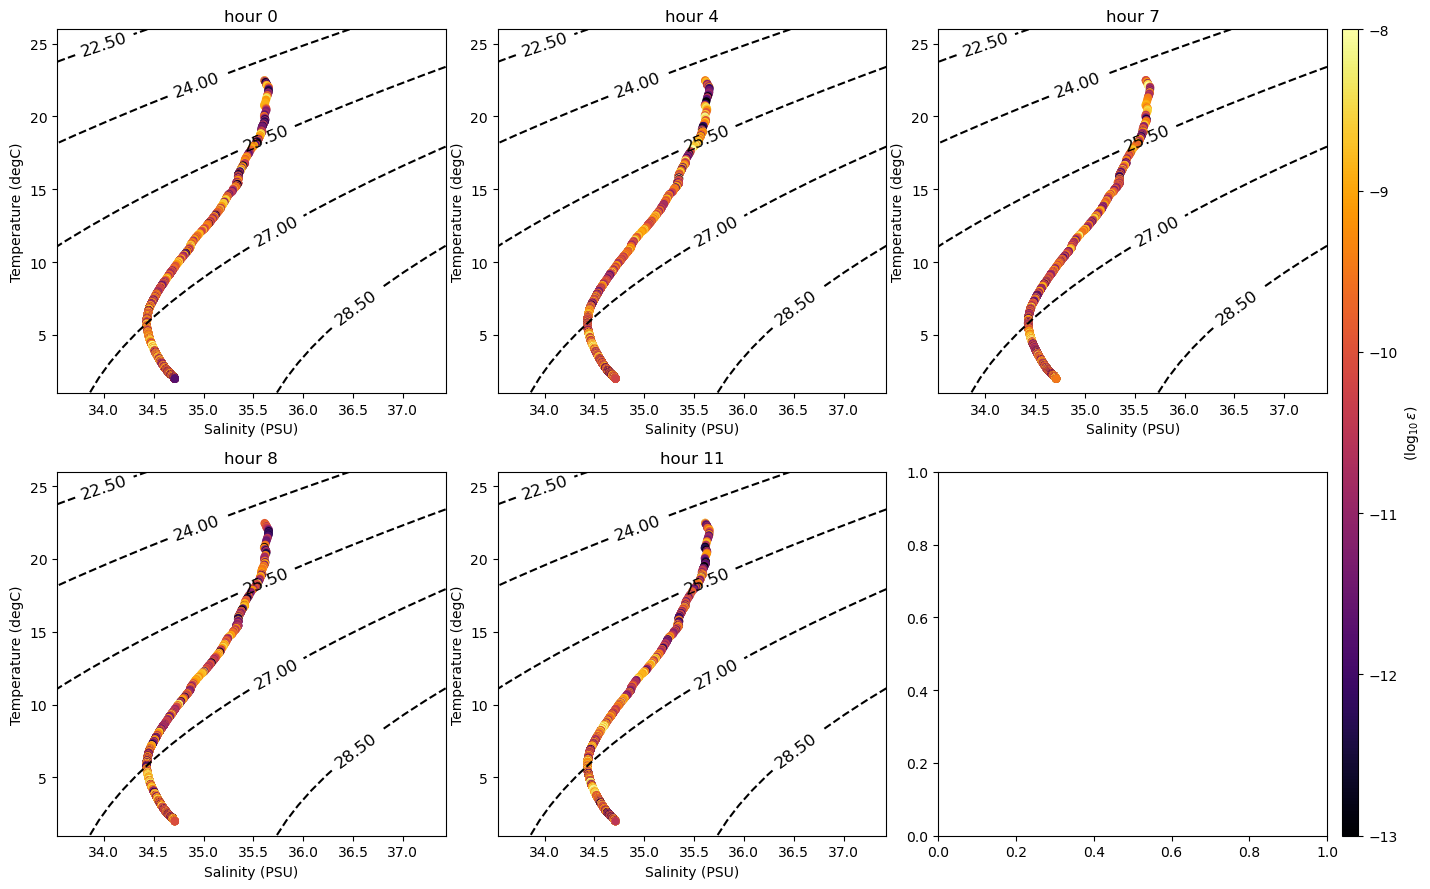

In [61]:
labels = ['hour 0', 'hour 4', 'hour 7', 'hour 8', 'hour 11']


# Load all datasets
datasets = {
    
    'dat_015': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc'),
    'dat_016': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_016.nc'),
    'dat_017': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_017.nc'),
    'dat_018': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_018.nc'),
    'dat_019': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_019.nc')
}

plot_ts_diagram(datasets, ctd_17, labels)

# Yoyo 2

Repeat same code as yoyo 1 for yoyos 2,3,4 

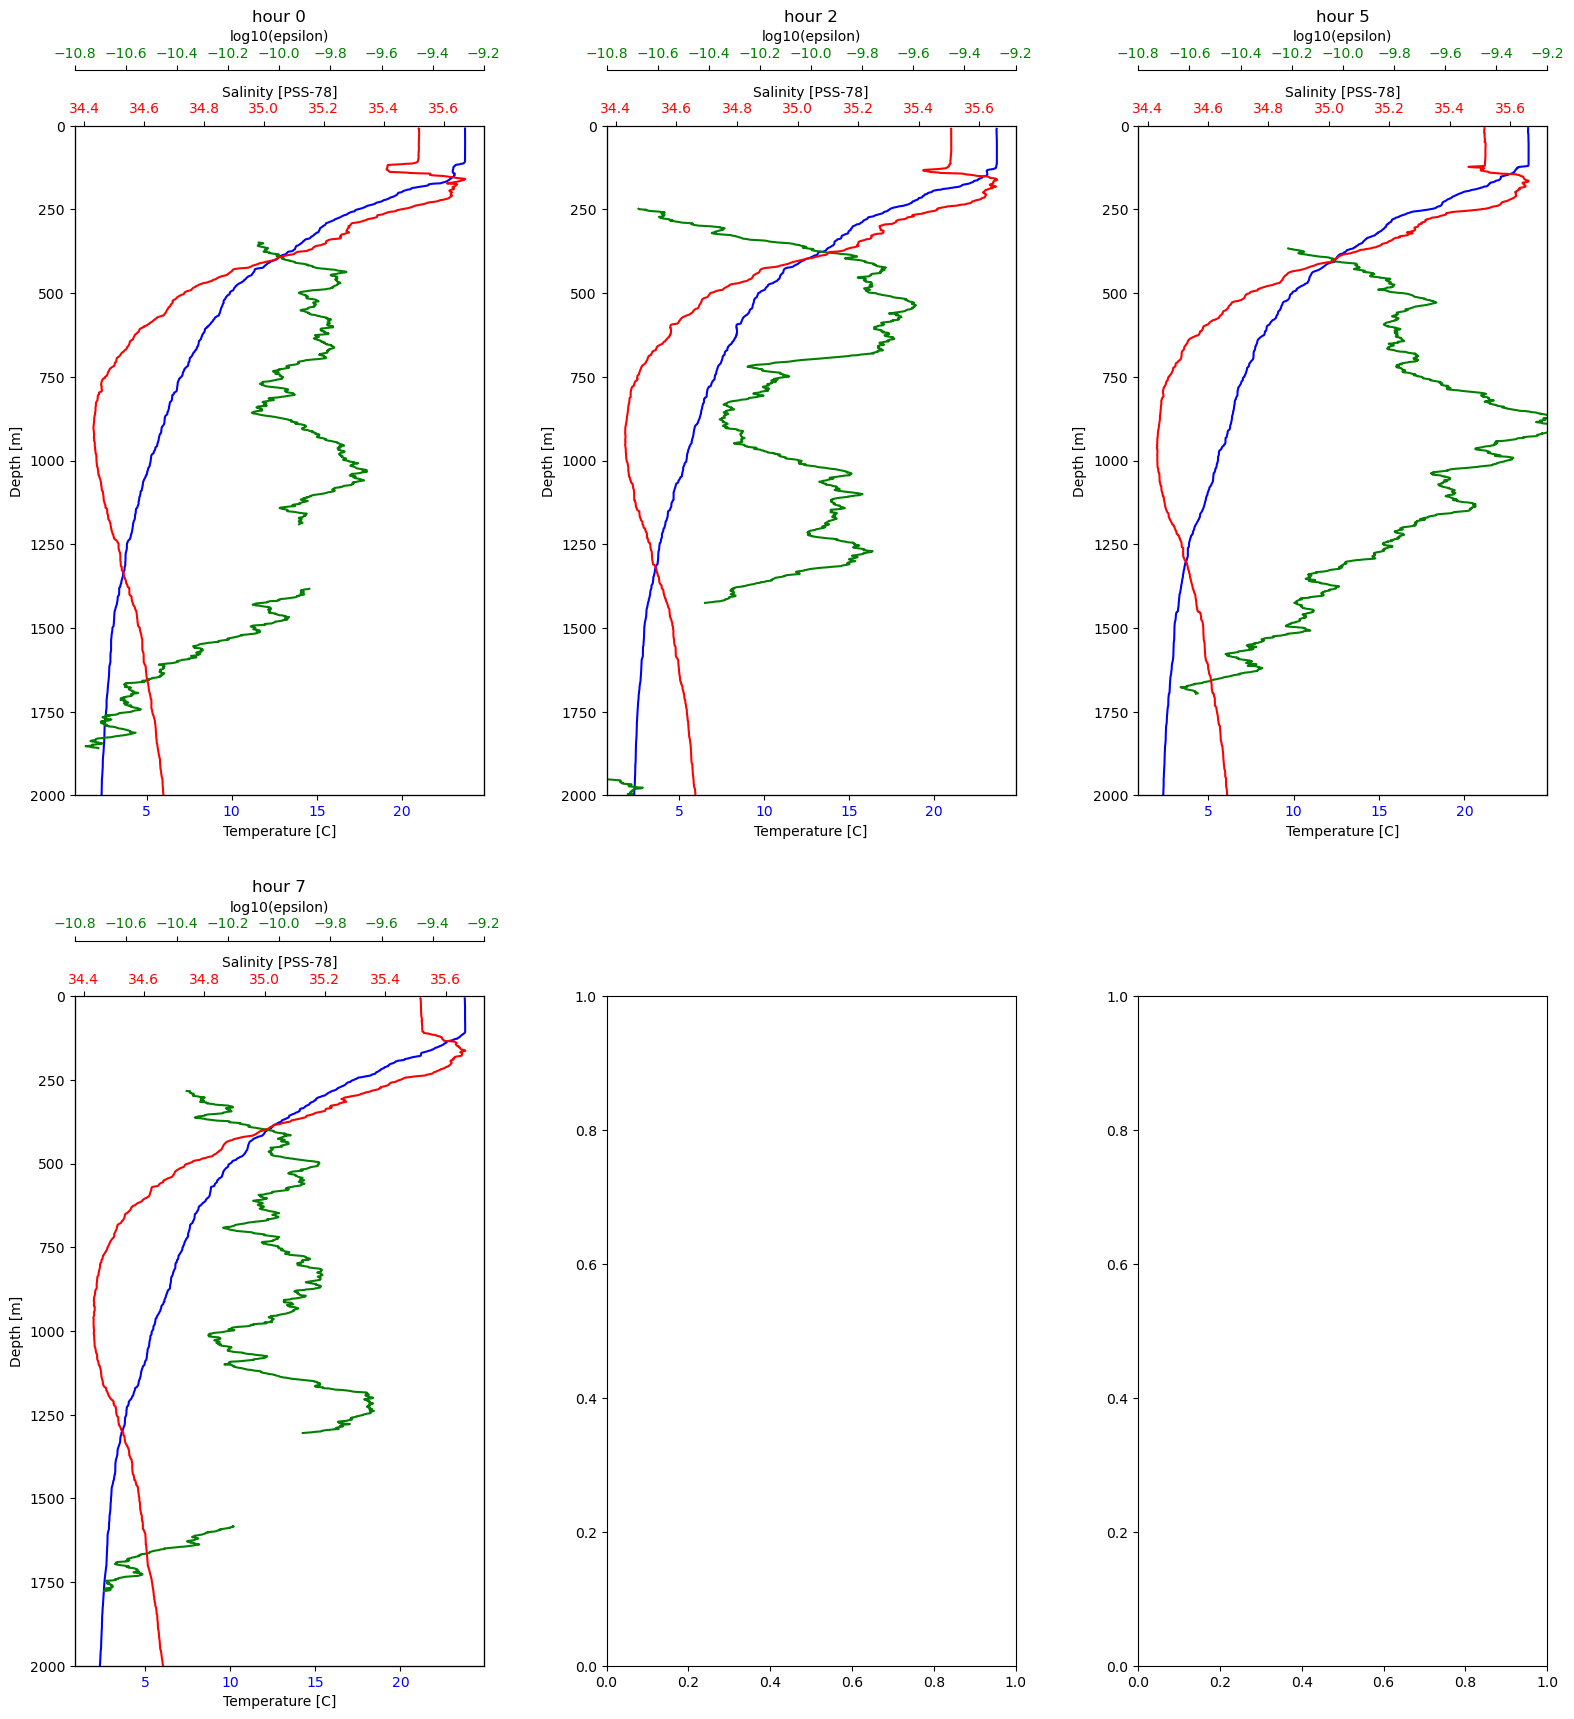

<Figure size 640x480 with 0 Axes>

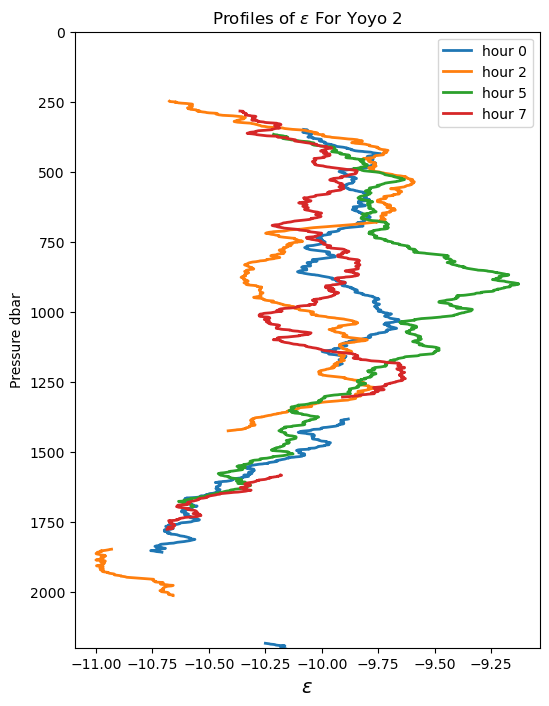

In [146]:


names = ['in2024_v04023CtdAvg.nc','in2024_v04024CtdAvg.nc','in2024_v04025CtdAvg.nc','in2024_v04026CtdAvg.nc']
# List all .nc files in the directory
ctd_23 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_24 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_25 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
ctd_26 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
# ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))

dat_020 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_020.nc')
dat_022 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_022.nc')
dat_023 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_023.nc')
dat_024 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_024.nc')
# dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
                         

# Create the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(19, 20))
axes = axes.flatten()
datasets= [ctd_23,ctd_24,ctd_25,ctd_26]

eps = [dat_020['eps'],dat_022['eps'],dat_023['eps'],dat_024['eps']]

label = ['hour 0', 'hour 2', 'hour 5','hour 7']

for i, data in enumerate(datasets):
    # Smoothing the log_epsilon data using a moving average with a window of 300
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=200, center=True).mean()

    # Extract the variables (replace 'temperature', 'salinity', 'oxygen', and 'epsilon' with your actual variable names)
    temperature = data['temperature'].isel(latitude=0, longitude=0,time=0)
    salinity = data['salinity'].isel(latitude=0, longitude=0,time=0)
    oxygen = data['oxygen'].isel(latitude=0, longitude=0,time=0)



    ax1 = axes[i]
    # Plot Temperature
    ax1.plot(temperature.values, data['pressure'].values, 'b-', label='Temperature [C]')
    ax1.set_xlabel('Temperature [C]')
    ax1.set_ylabel('Depth [m]')
    ax1.invert_yaxis()
    ax1.tick_params(axis='x', labelcolor='b')


    # Create another x-axis for log10(epsilon)
    ax2 = ax1.twiny()
    ax2.spines['top'].set_position(('outward', 40))
    ax2.plot(smoothed_log_epsilon, eps[i].pressure.values, 'g-', label='log10(epsilon)')
    ax2.set_xlabel('log10(epsilon)')
    ax2.tick_params(axis='x', labelcolor='g')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(-10.8, -9.2)

    ax2.set_ylim(2000, 0)


    # Create another x-axis for salinity
    ax3 = ax1.twiny()
    ax3.plot(salinity.values,data['pressure'].values, 'r-', label='Salinity [PSS-78]')
    ax3.set_xlabel('Salinity [PSS-78]')
    ax3.tick_params(axis='x', labelcolor='r')


    # Create another x-axis for oxygen
    # ax4 = ax1.twiny()
    # ax4.spines['top'].set_position(('outward', 50))
    # ax4.plot(oxygen.values, ds['pressure'].values, 'm-', label='Oxygen [micromole/kg]')
    # ax4.set_xlabel('Oxygen [micromole/kg]')
    # ax4.tick_params(axis='x', labelcolor='m')


    ax1.set_title(label[i])


plt.subplots_adjust(hspace=0.3, wspace=0.3)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(2)
plt.figure(figsize=(6, 8))

# Loop over each field in chi
for i, label in enumerate(label):

    # Get epsilon
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=200, center=True).mean()


    # Plot profiles
    plt.plot(smoothed_log_epsilon, eps[i].pressure.values, linewidth=2.0, label=label, color=colors[i])

    # Add x-axis label
    plt.xlabel(r'$\epsilon$', fontsize=14)

    # Add y-axis label
    plt.ylabel('Pressure dbar')
    plt.gca().invert_yaxis()
    plt.ylim(2200, 0)
    plt.legend()
    plt.title('Profiles of $\epsilon$ For Yoyo 2')


plt.show()


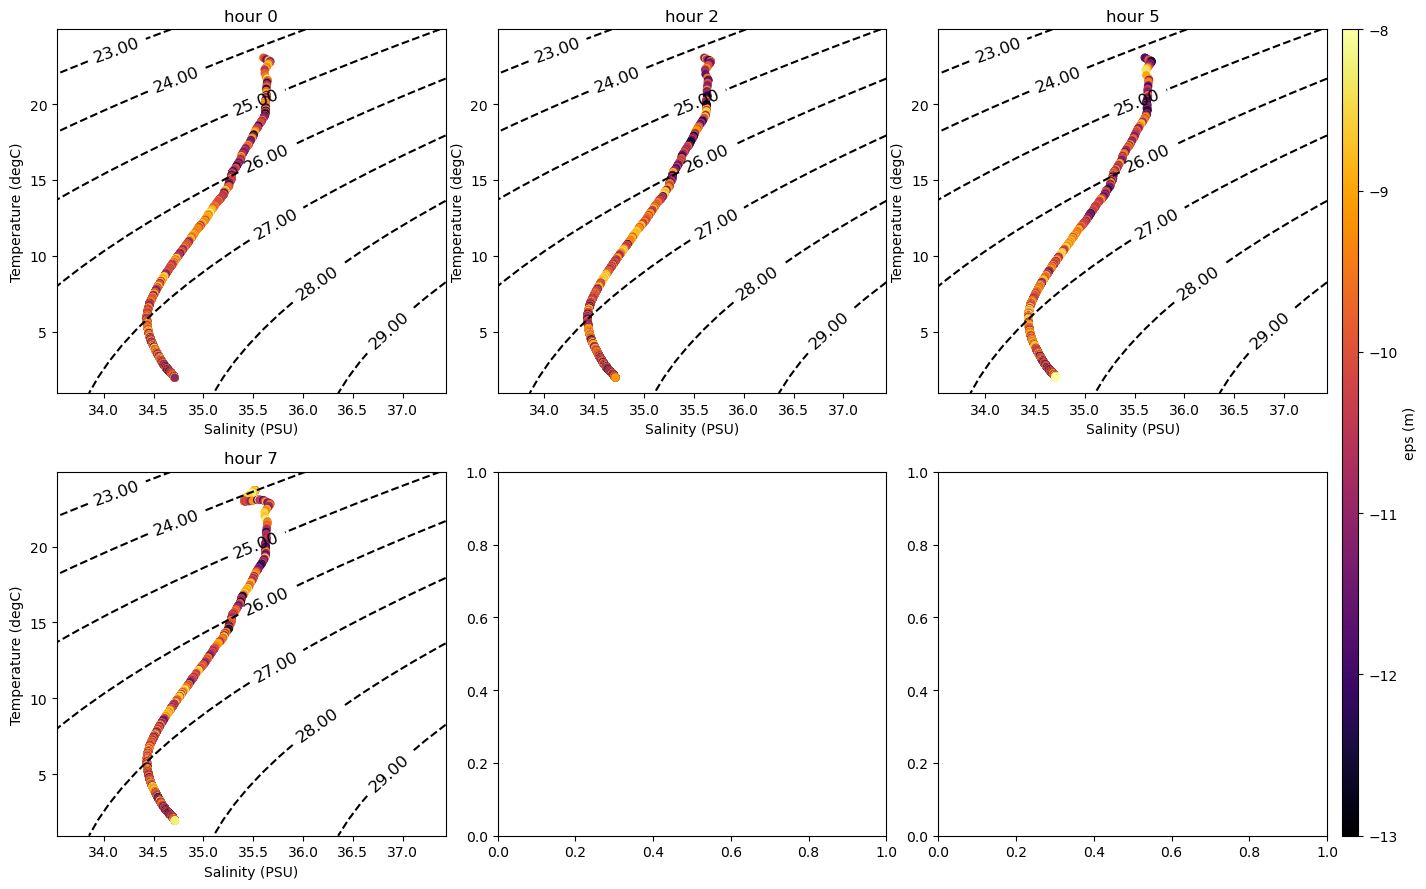

In [184]:
labels = ['hour 0', 'hour 2', 'hour 5','hour 7']


names = ['in2024_v04023CtdAvg.nc','in2024_v04024CtdAvg.nc','in2024_v04025CtdAvg.nc','in2024_v04026CtdAvg.nc']
# List all .nc files in the directory
ctd_23 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_24 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_25 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
ctd_26 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))

datasets = {
    'dat_020': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_020.nc'),
    'dat_022': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_022.nc'),
    'dat_023': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_023.nc'),
    'dat_024': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_024.nc')
}


plot_ts_diagram(datasets, ctd_23,labels)

## yo yo 3

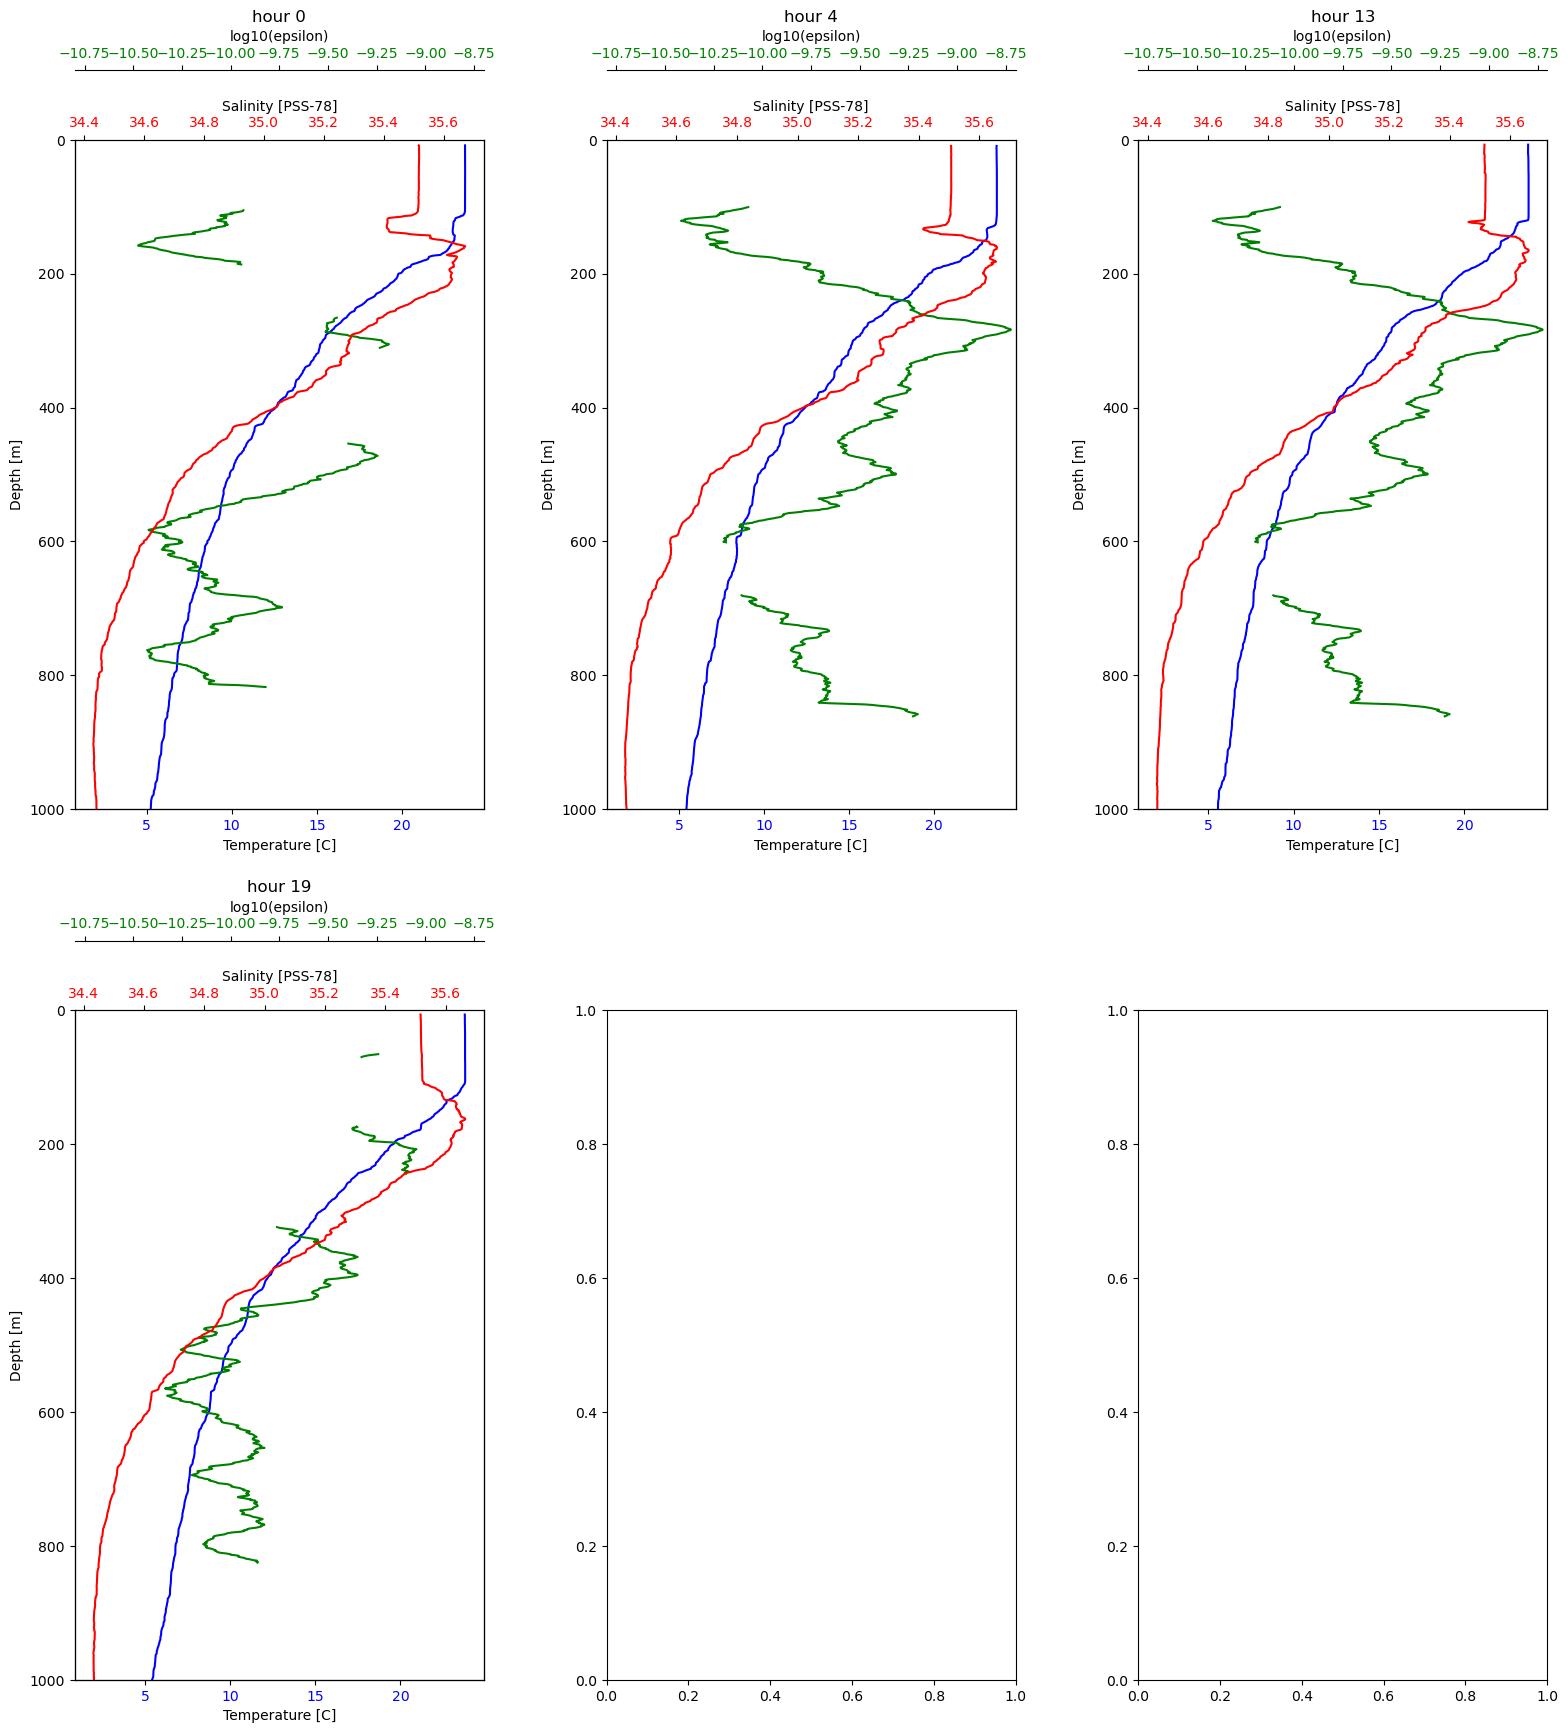

<Figure size 640x480 with 0 Axes>

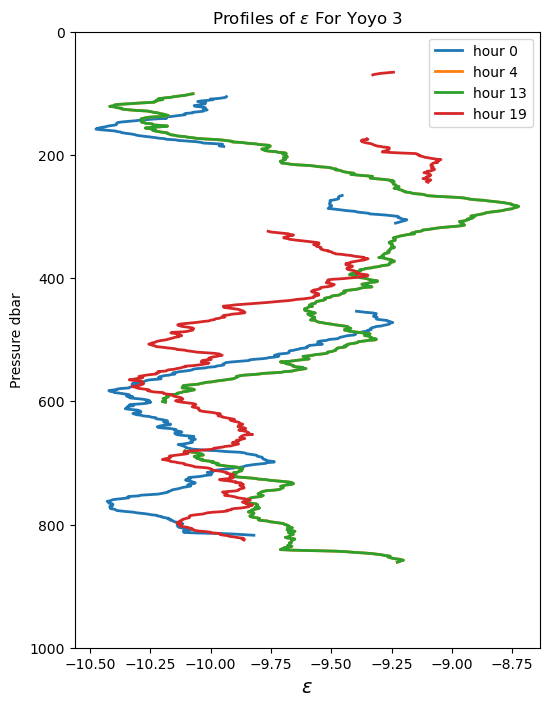

In [148]:


names = ['in2024_v04023CtdAvg.nc','in2024_v04024CtdAvg.nc','in2024_v04025CtdAvg.nc','in2024_v04026CtdAvg.nc']
# List all .nc files in the directory
ctd_39 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_41 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_45 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
ctd_47 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
# ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))

dat_025 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_025.nc')
dat_027 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_027.nc')
dat_028 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_028.nc')
dat_030 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_030.nc')
# dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
                         

# Create the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(19, 20))
axes = axes.flatten()
datasets= [ctd_39,ctd_41,ctd_45,ctd_47]

eps = [dat_025['eps'],dat_027['eps'],dat_028['eps'],dat_030['eps']]

label = ['hour 0', 'hour 4', 'hour 13','hour 19']

for i, data in enumerate(datasets):
    # Smoothing the log_epsilon data using a moving average with a window of 300
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=80, center=True).mean()

    # Extract the variables (replace 'temperature', 'salinity', 'oxygen', and 'epsilon' with your actual variable names)
    temperature = data['temperature'].isel(latitude=0, longitude=0,time=0)
    salinity = data['salinity'].isel(latitude=0, longitude=0,time=0)
    oxygen = data['oxygen'].isel(latitude=0, longitude=0,time=0)



    ax1 = axes[i]
    # Plot Temperature
    ax1.plot(temperature.values, data['pressure'].values, 'b-', label='Temperature [C]')
    ax1.set_xlabel('Temperature [C]')
    ax1.set_ylabel('Depth [m]')
    ax1.invert_yaxis()
    ax1.tick_params(axis='x', labelcolor='b')


    # Create another x-axis for log10(epsilon)
    ax2 = ax1.twiny()
    ax2.spines['top'].set_position(('outward', 50))
    ax2.plot(smoothed_log_epsilon, eps[i].pressure.values, 'g-', label='log10(epsilon)')
    ax2.set_xlabel('log10(epsilon)')
    ax2.tick_params(axis='x', labelcolor='g')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(-10.8, -8.7)

    ax2.set_ylim(1000, 0)


    # Create another x-axis for salinity
    ax3 = ax1.twiny()
    ax3.plot(salinity.values,data['pressure'].values, 'r-', label='Salinity [PSS-78]')
    ax3.set_xlabel('Salinity [PSS-78]')
    ax3.tick_params(axis='x', labelcolor='r')


    # Create another x-axis for oxygen
    # ax4 = ax1.twiny()
    # ax4.spines['top'].set_position(('outward', 50))
    # ax4.plot(oxygen.values, ds['pressure'].values, 'm-', label='Oxygen [micromole/kg]')
    # ax4.set_xlabel('Oxygen [micromole/kg]')
    # ax4.tick_params(axis='x', labelcolor='m')


    ax1.set_title(label[i])


plt.subplots_adjust(hspace=0.3, wspace=0.3)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
labs =  ['hour 0', 'hour 4', 'hour 13','hour 19']


plt.figure(2)
plt.figure(figsize=(6, 8))

# Loop over each field in chi
for i, label in enumerate(label):

    # Get epsilon
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=80, center=True).mean()


    # Plot profiles
    plt.plot(smoothed_log_epsilon, eps[i].pressure.values, linewidth=2.0, label=label, color=colors[i])

    # Add x-axis label
    plt.xlabel(r'$\epsilon$', fontsize=14)

    # Add y-axis label
    plt.ylabel('Pressure dbar')
    plt.gca().invert_yaxis()
    plt.ylim(1000, 0)
    plt.legend()
    plt.title('Profiles of $\epsilon$ For Yoyo 3')





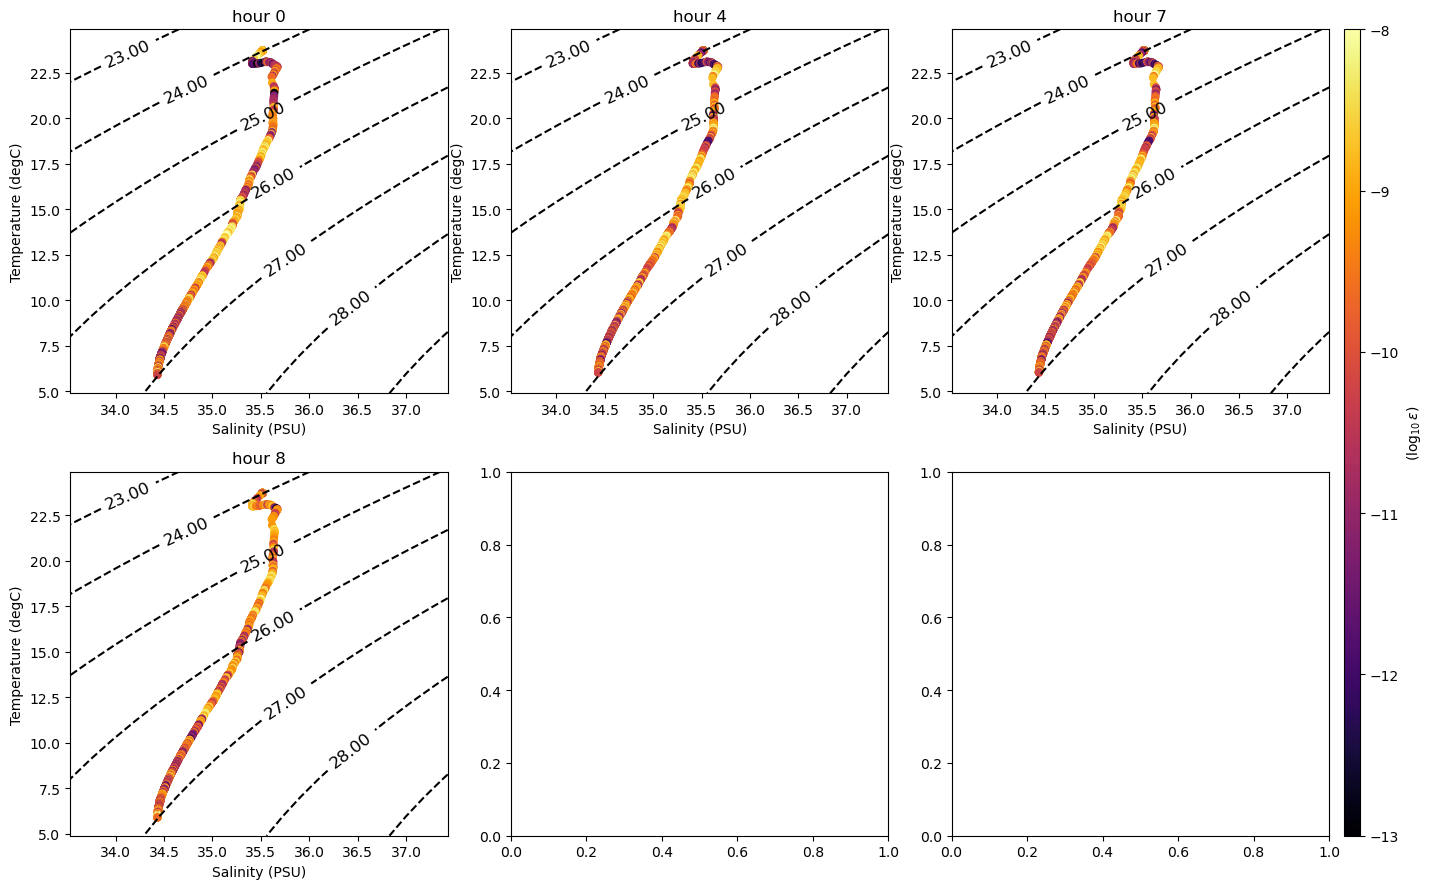

In [456]:
label = ['hour 0', 'hour 4', 'hour 13','hour 19']


names = ['in2024_v04023CtdAvg.nc','in2024_v04024CtdAvg.nc','in2024_v04025CtdAvg.nc','in2024_v04026CtdAvg.nc']
# List all .nc files in the directory
ctd_39 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_41 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_45 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
ctd_47 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
# ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))

dat_025 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_025.nc')
dat_027 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_027.nc')
dat_028 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_028.nc')
dat_030 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_030.nc')
# dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
          


datasets = {
    'dat_025': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_025.nc'),
    'dat_027': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_027.nc'),
    'dat_028': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_028.nc'),
    'dat_030': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_030.nc')
}

plot_ts_diagram(datasets, ctd_39, labels)

## yo yo 4

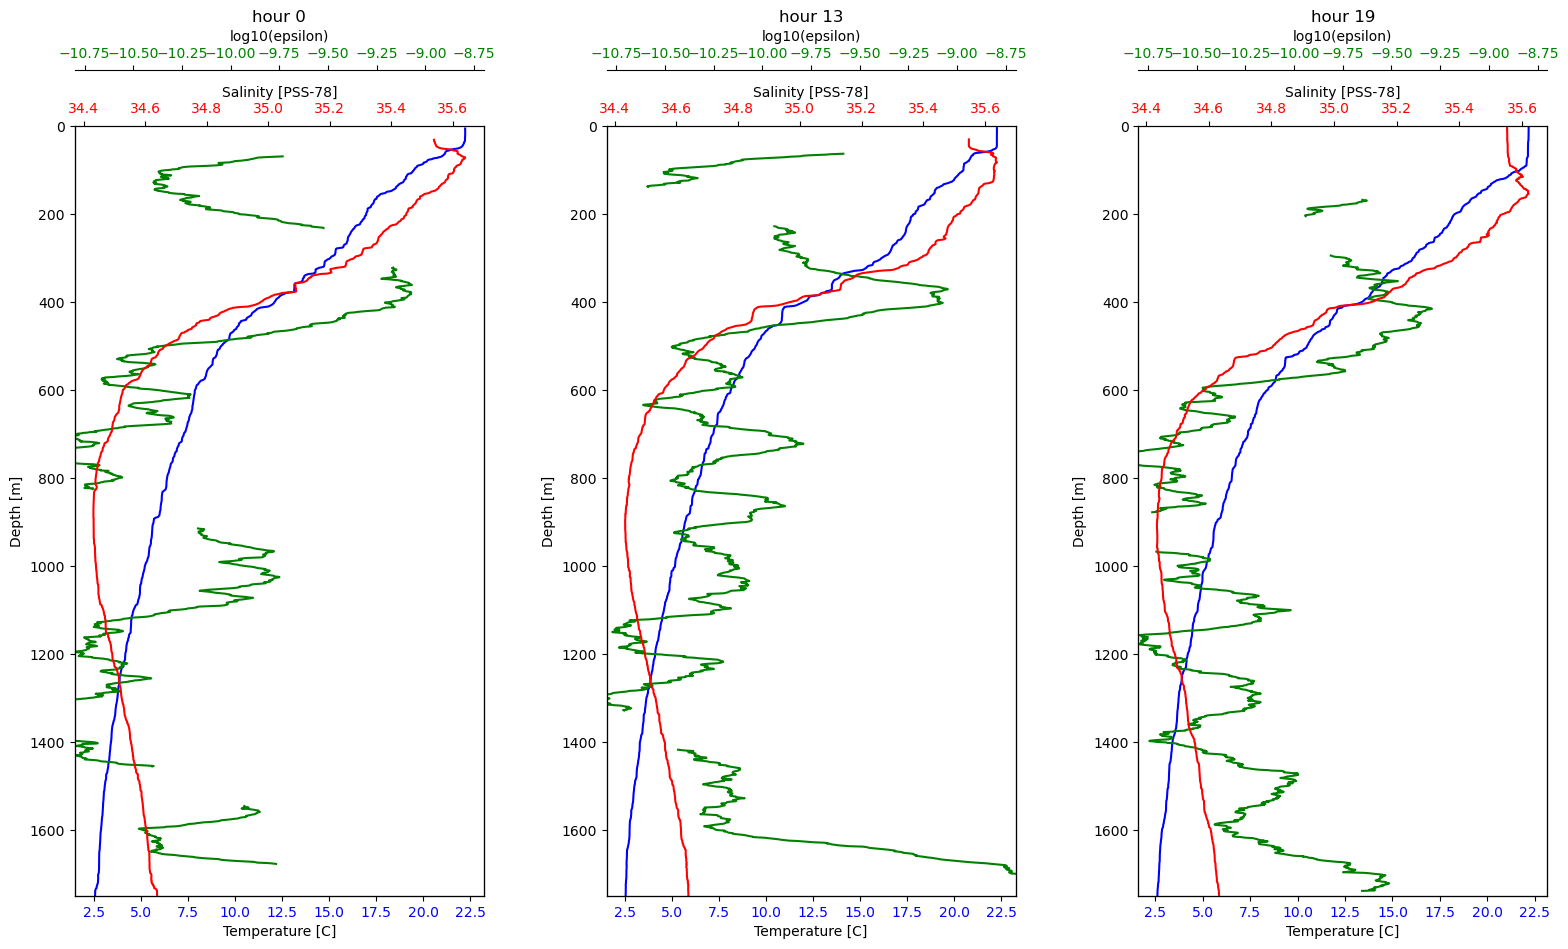

<Figure size 640x480 with 0 Axes>

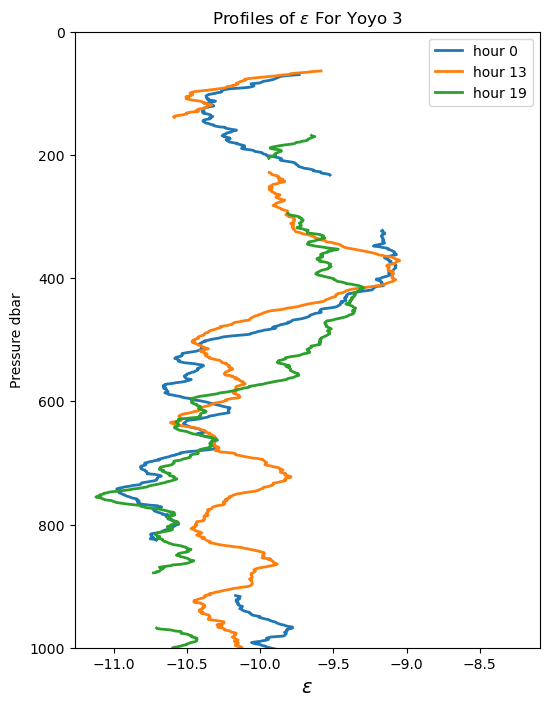

In [457]:

label = ['hour 0', 'hour 13', 'hour 19']

names = ['in2024_v04040CtdAvg.nc','in2024_v04046CtdAvg.nc','in2024_v04048CtdAvg.nc']
# List all .nc files in the directory
ctd_40 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_46 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_48 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
# ctd_47 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
# ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))

dat_026 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_026.nc')
dat_029 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_029.nc')
dat_031 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_031.nc')
# dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
                         

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(19, 10))
axes = axes.flatten()
datasets= [ctd_40,ctd_46,ctd_48]

eps = [dat_026['eps'],dat_029['eps'],dat_031['eps']]

label = ['hour 0', 'hour 13', 'hour 19']

for i, data in enumerate(datasets):
    # Smoothing the log_epsilon data using a moving average with a window of 300
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=90, center=True).mean()

    # Extract the variables (replace 'temperature', 'salinity', 'oxygen', and 'epsilon' with your actual variable names)
    temperature = data['temperature'].isel(latitude=0, longitude=0,time=0)
    salinity = data['salinity'].isel(latitude=0, longitude=0,time=0)
    oxygen = data['oxygen'].isel(latitude=0, longitude=0,time=0)



    ax1 = axes[i]
    # Plot Temperature
    ax1.plot(temperature.values, data['pressure'].values, 'b-', label='Temperature [C]')
    ax1.set_xlabel('Temperature [C]')
    ax1.set_ylabel('Depth [m]')
    ax1.invert_yaxis()
    ax1.tick_params(axis='x', labelcolor='b')


    # Create another x-axis for log10(epsilon)
    ax2 = ax1.twiny()
    ax2.spines['top'].set_position(('outward', 40))
    ax2.plot(smoothed_log_epsilon, eps[i].pressure.values, 'g-', label='log10(epsilon)')
    ax2.set_xlabel('log10(epsilon)')
    ax2.tick_params(axis='x', labelcolor='g')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(-10.8, -8.7)

    ax2.set_ylim(1750, 0)


    # Create another x-axis for salinity
    ax3 = ax1.twiny()
    ax3.plot(salinity.values,data['pressure'].values, 'r-', label='Salinity [PSS-78]')
    ax3.set_xlabel('Salinity [PSS-78]')
    ax3.tick_params(axis='x', labelcolor='r')


    # Create another x-axis for oxygen
    # ax4 = ax1.twiny()
    # ax4.spines['top'].set_position(('outward', 50))
    # ax4.plot(oxygen.values, ds['pressure'].values, 'm-', label='Oxygen [micromole/kg]')
    # ax4.set_xlabel('Oxygen [micromole/kg]')
    # ax4.tick_params(axis='x', labelcolor='m')


    ax1.set_title(label[i])


plt.subplots_adjust(hspace=0.5, wspace=0.3)




colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


plt.figure(2)
plt.figure(figsize=(6, 8))

# Loop over each field in chi
for i, label in enumerate(label):

    # Get epsilon
    smoothed_log_epsilon = pd.Series(eps[i].values).rolling(window=90, center=True).mean()


    # Plot profiles
    plt.plot(smoothed_log_epsilon, eps[i].pressure.values, linewidth=2.0, label=label, color=colors[i])

    # Add x-axis label
    plt.xlabel(r'$\epsilon$', fontsize=14)

    # Add y-axis label
    plt.ylabel('Pressure dbar')
    plt.gca().invert_yaxis()
    plt.ylim(1000, 0)
    plt.legend()
    plt.title('Profiles of $\epsilon$ For Yoyo 3')




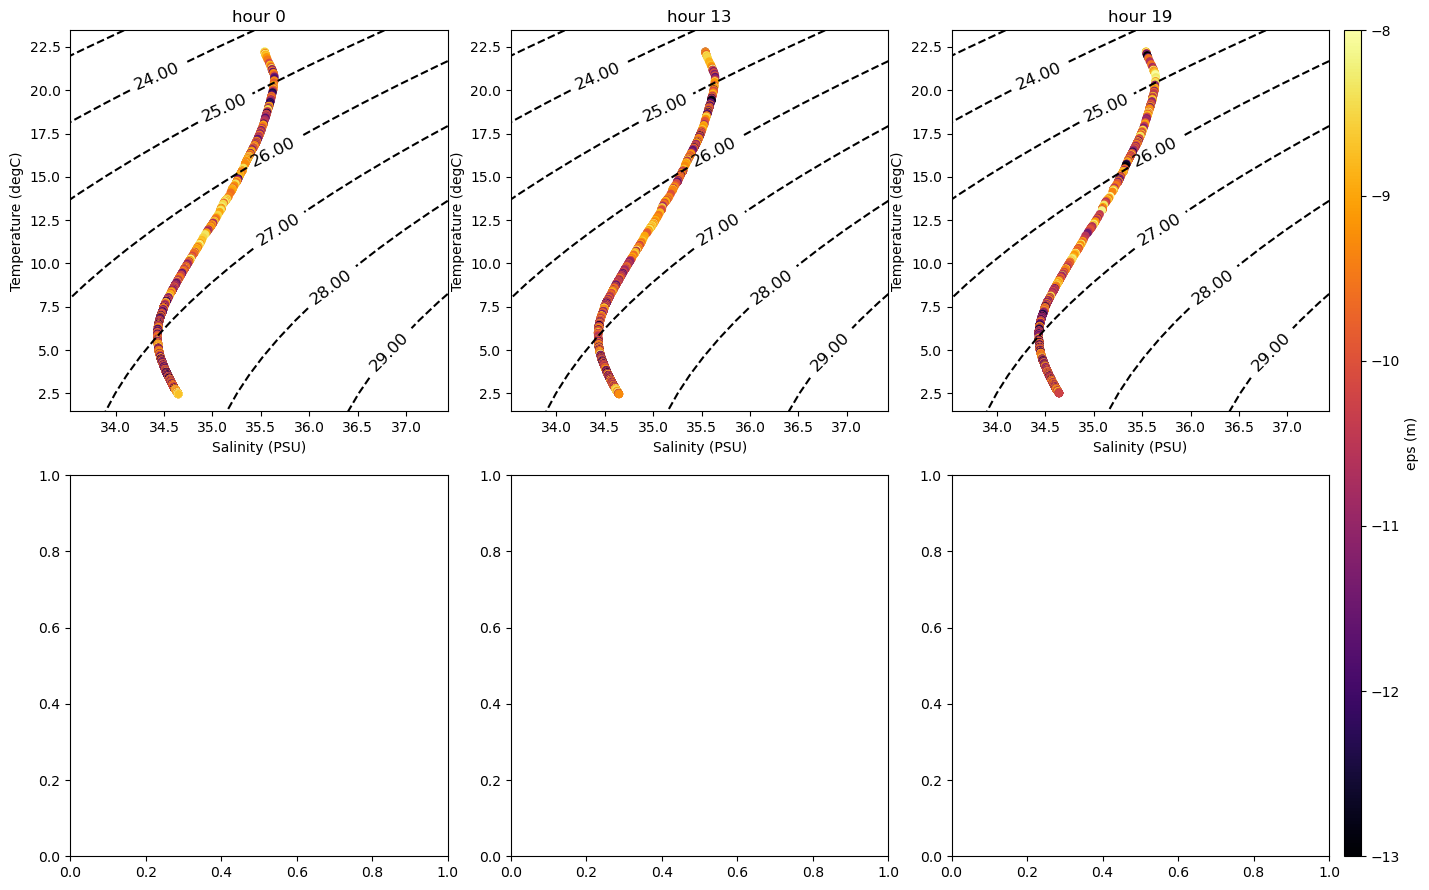

In [186]:
labels = ['hour 0', 'hour 13', 'hour 19']


names = ['in2024_v04040CtdAvg.nc','in2024_v04046CtdAvg.nc','in2024_v04048CtdAvg.nc']
# List all .nc files in the directory
ctd_40 = xr.open_dataset(os.path.join(nc_files_dir, names[0]))
ctd_46 = xr.open_dataset(os.path.join(nc_files_dir, names[1]))
ctd_48 = xr.open_dataset(os.path.join(nc_files_dir, names[2]))
# ctd_47 = xr.open_dataset(os.path.join(nc_files_dir, names[3]))
# ctd_21 = xr.open_dataset(os.path.join(nc_files_dir, names[4]))

dat_026 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_026.nc')
dat_029 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_029.nc')
dat_031 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_031.nc')
# dat_019 =xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_015.nc')
      
datasets = {
    'dat_026': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_026.nc'),
    'dat_029': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_029.nc'),
    'dat_031': xr.open_dataset('/Users/isabelaconde/Documents/microstructure/data/eps_chi_DAT_031.nc')
}

plot_ts_diagram(datasets, ctd_40, labels)

## yo yo 5